In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import scipy.signal as sg
import scipy as sp
from mpl_toolkits import mplot3d
import ellipses as el
from matplotlib.patches import Ellipse
%matplotlib inline
# helper functions
# ellipse fitting function
def efit(data, isleft=0):
    if (isleft == 0):
        maxrl = maxpR
    else:
        maxrl = maxpL
    lsqe = el.LSqEllipse()
    lsqe.fit(data)
    center, width, height, phi = lsqe.parameters()
    plt.close('all')
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.axis('equal')
    ax.plot(data[0], data[1], 'ro', label='test data', zorder=1)
    ax.imshow(imgEye[isleft], cmap='gray')
    plt.plot(maxrl[1], maxrl[0], 'y+')
    ellipse = Ellipse(xy=center, width=2*width, height=2*height, angle=np.rad2deg(phi),
                   edgecolor='b', fc='None', lw=2, label='Fit', zorder = 2)
    ax.add_patch(ellipse)
    arrow = plt.Arrow(x=maxrl[1], y=maxrl[0], dx=center[0]-maxrl[1], dy=center[1]-maxrl[0], width=30)
    ax.add_patch(arrow)
    vector = [(center[0]-maxrl[1]), (center[1]-maxrl[0])]
    vecmag = np.sqrt(vector[0]**2+vector[1]**1)
    plt.title('Gaze Vector Mag = '+str(round(vecmag,1))+' pixels')
    plt.plot(center[0],center[1], 'g+')
    plt.legend()
    plt.show()
#     plt.savefig('r20.jpg')
    return (center, vector)

#circle fitting
def cfit(data, isleft = 0):  
    if (isleft == 0):
        maxrl = maxpR
    else:
        maxrl = maxpL
    # coordinates of the barycenter
    x = data[0]
    y = data[1]
    x_m = np.mean(x)
    y_m = np.mean(y)
    
    # calculation of the reduced coordinates
    u = x - x_m
    v = y - y_m
    
    # linear system defining the center (uc, vc) in reduced coordinates:
    #    Suu * uc +  Suv * vc = (Suuu + Suvv)/2
    #    Suv * uc +  Svv * vc = (Suuv + Svvv)/2
    Suv  = sum(u*v)
    Suu  = sum(u**2)
    Svv  = sum(v**2)
    Suuv = sum(u**2 * v)
    Suvv = sum(u * v**2)
    Suuu = sum(u**3)
    Svvv = sum(v**3)
    
    # Solving the linear system
    A = np.array([ [ Suu, Suv ], [Suv, Svv]])
    B = np.array([ Suuu + Suvv, Svvv + Suuv ])/2.0
    uc, vc = np.linalg.solve(A, B)
    
    xc_1 = x_m + uc
    yc_1 = y_m + vc
    
    # Calcul des distances au centre (xc_1, yc_1)
    Ri_1     = np.sqrt((x-xc_1)**2 + (y-yc_1)**2)
    R_1      = np.mean(Ri_1)
    residu_1 = sum((Ri_1-R_1)**2)
    
    center = (xc_1, yc_1)
#     vector = [(center[0]-maxpR[1]), (center[1]-maxpR[0])]
#     vecmag = np.sqrt(vector[0]**2+vector[1]**1)
   
    plt.close('all')
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)
    ax.axis('equal')
    ax.plot(data[0], data[1], 'ro', label='test data', zorder=1)
#     ax.imshow(imgEye[0], cmap='gray')
#     plt.plot(maxpR[1], maxpR[0], 'y+')
    
    circle = plt.Circle(center,R_1, fill = False)
    ax.add_patch(circle)
    plt.plot(center[0],center[1], 'g+')
    plt.legend()
    plt.imshow(imgEye[isleft])
    arrow = plt.Arrow(x=maxrl[1], y=maxrl[0], dx=center[0]-maxrl[1], dy=center[1]-maxrl[0], width=30)
    ax.add_patch(arrow)
    vector = [(center[0]-maxrl[1]), (center[1]-maxrl[0])]
    return center, vector


# remove noise
def debubble(cpos, cneg, rpos, rneg, win_, isleft = 0):
#     input: xcor of edge points
#     ncol: number of column
#     posfirst: posedge happens before negedge
    counts = np.bincount(cpos)
    pmode = np.argmax(counts)
    counts2 = np.bincount(cneg)
    nmode = np.argmax(counts2)
    ta1 = np.zeros(len(cpos)).astype('bool')
    ta2 = np.zeros(len(cneg)).astype('bool')
    print('truncation: ', pmode, '+-', win_)
    print('truncation: ', nmode, '+-', win_)
    for i in range(len(cpos)):
        ta1[i] = (cpos<(pmode+win_))[i] and (cpos>(pmode-win_))[i]
        ta2[i] = (cneg<(nmode+win_))[i] and (cneg>(nmode-win_))[i]
    boolret = (nmode < pmode) if (isleft==0) else (nmode > pmode)
    return cpos[ta1], cneg[ta2], rpos[ta1], rneg[ta2], boolret
# parameters:
zoomout = 1.2 # 
ratio = .30
ratio1 = .68
narrower = 0 
pns = 140
nns = 140
win = 6 # bilateral window size in pixel
print ('modules imported')

modules imported


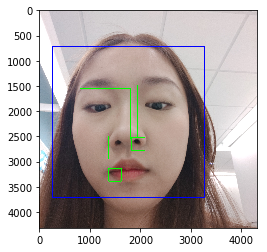

In [85]:
#   faces eyes detection
face_cascade = cv.CascadeClassifier('C:\\Users\\wangy\\Anaconda2\\Lib\\site-packages\\cv2\\data\\haarcascade_frontalface_default.xml')
eye_cascade = cv.CascadeClassifier('C:\\Users\\wangy\\Anaconda2\\Lib\\site-packages\\cv2\\data\\haarcascade_eye.xml')
if (eye_cascade.empty()==True or face_cascade.empty()==True):
    print ('Fail to load xml data')
imgEye = []
img = cv.imread('wyc8.jpg')
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray')
faces = face_cascade.detectMultiScale(gray, 1.3, 5)
if(len(faces) == 0):
    print("Face dectection failure")
for (x,y,w,h) in faces:
    cv.rectangle(img,(x,y),(x+w,y+h),(255,0,0),20)
    roi_gray = gray[y:y+h, x:x+w]
    plt.imshow(roi_gray,cmap='gray')
    roi_color = img[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ex,ey,ew,eh) in eyes:
        imgEye.append(cv.cvtColor(roi_color[ey+narrower:ey+(int)(ew), ex:ex+(int)(eh*zoomout)], cv.COLOR_BGR2GRAY))
        cv.rectangle(roi_color,(ex,ey),(ex+(int)(ew*1.4),ey+(int)(eh*1.4)),(0,255,0),10)

plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
# plt.savefig('face20.jpg')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


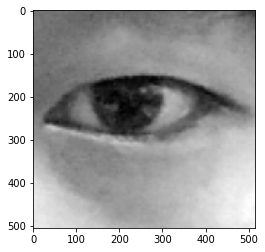

In [4]:
# From eyes file
imgEye = []
eyefile = sp.misc.imread('l_eye.png')
eyefile = cv.cvtColor(eyefile, cv.COLOR_BGR2GRAY)
plt.imshow(eyefile, cmap='gray')
imgEye.append(eyefile)

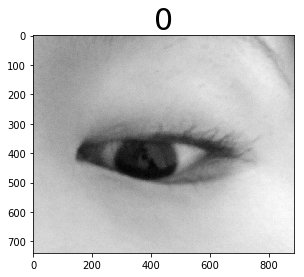

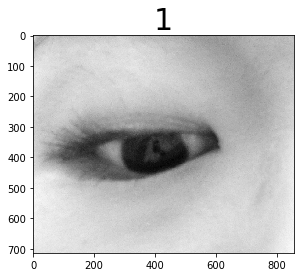

In [87]:
#  export eyes' img
imgEye = [imgEye[1],imgEye[0]]# manually delete wrong pic
if(len(imgEye) == 0): print('Fail to detect eyes')
for i in range (len(imgEye)):
    fig = plt.figure()
    plt.imshow(imgEye[i], cmap='gray')
    plt.title(str(i),fontsize=30)

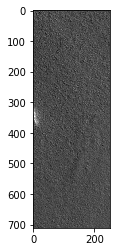

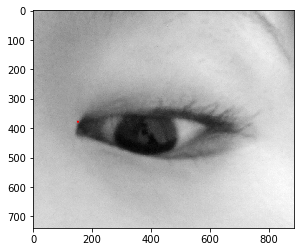

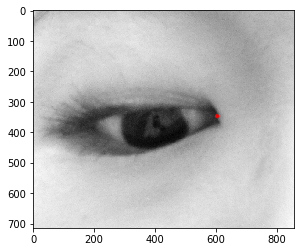

In [92]:
#  eye corner localization 
cfR = np.array([[-1,-1,-1, 1, 1, 1],
                [-1,-1,-1,-1, 1, 1],
                [-1,-1,-1,-1,-1, 1],
                [ 1, 1, 1, 1, 1, 1]])
cfL = np.array([[1,1,1,-1,-1,-1],[1,1,-1,-1,-1,-1],[1,-1,-1,-1,-1,-1],[1,1,1,1,1,1]])
# print('right eye filter:')
# print (cfR)
# print('left  eye filter:')
# print (cfL)
foR = sg.convolve2d(imgEye[0][:,:(int)(imgEye[0].shape[1]*ratio)], cfR, mode='valid')
maxpR = np.array([(int) (np.argmax(foR)/foR.shape[1]), np.argmax(foR)%foR.shape[1]])
foL = sg.convolve2d(imgEye[1][:,-(int)(imgEye[1].shape[1]*ratio):], cfL, mode='valid')
plt.figure()
plt.imshow(foL,cmap='gray')
maxpL = np.array([(int) (np.argmax(foL)/foL.shape[1]), np.argmax(foL)%foL.shape[1]])
maxpL[1] = maxpL[1] + (int)(imgEye[1].shape[1]*(1-ratio))

fig, ax = plt.subplots(1)
ax.imshow(imgEye[0],cmap='gray')
ax.add_patch(plt.Circle((maxpR[1], maxpR[0]), radius=2, color='red'))

fig, ax = plt.subplots(1)
ax.imshow(imgEye[1],cmap='gray')
ax.add_patch(plt.Circle((maxpL[1], maxpL[0]), radius=5, color='red'))
# plt.figure()

[[   0.   14.   -4. ...  176.    4. -128.]
 [   0.    7.   -3. ...  174.  -17. -171.]
 [   0.    8.   11. ...  119.  -86. -244.]
 ...
 [   0.  -29.  -61. ...  -84.  -98.  -25.]
 [   0.    2.  -52. ...  -71.  -80.   -2.]
 [   0.   16.  -48. ...  -50.  -60.   10.]]
[ 58  56 123 124  49  47  55 119 125 115 125 117  58  45  55 114 124  59
 121  55  57  45  51  59  88 118  58  44 115  52  51 119 124 125  48  51
  53 113  59  57  56  89  54 114 124 125 120 122  58 125 124  58  46  57
  52 124 122 125  47  55 117  52  46  51 113  54 122 118 119 114  55  50
  50  58  56  57  52  47  52  48  49  50 116 118  52  51  45 115  56  47
  45 116  51 115  50 117  55  51 121  46  47  48  47 120  55  45 117 121
  50  57  46  48  49 120 116  48  46  49  56  51  48  50  49  48  49  48
  49  57 121  51  56  50  49  51  51  49  50  49  50  50]
[ 88  80  78  80  77  85  79  90  80  95  75  94  87  80  81  95  75  88
  88  82  90  84  83  86 102  93  86  82  92  84  82  92  79  79  86  87
  77  95  87  89  79 

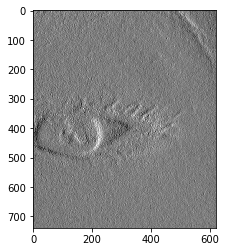

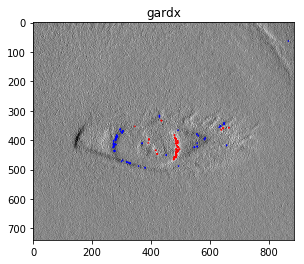

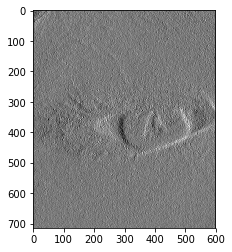

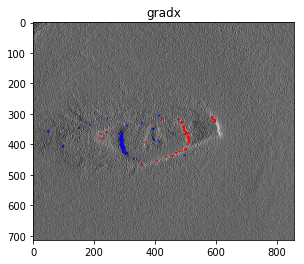

In [93]:
gradx = cv.Sobel(imgEye[0],cv.CV_64F,1,0,ksize=5)
gradx_ = gradx.copy()

gradx = gradx[:,(int)(imgEye[0].shape[1]*ratio):]
plt.figure()
plt.imshow(gradx,cmap='gray')
row, col = gradx.shape[0], gradx.shape[1]
fig, ax = plt.subplots(1)
ax.imshow((gradx_),cmap='gray')
plt.title('gardx')

ranks = np.argsort(gradx.flatten())
cargpR = (ranks[-pns:] % col).astype('int')
rargpR = (ranks[-pns:] / col).astype('int')
cargpR += (int) ((imgEye[0].shape[1])*ratio)
for i in range(pns):
    ax.add_patch(plt.Circle((cargpR[i], rargpR[i]), radius=1, color='red'))
cargnR = (ranks[0:nns] % col).astype('int')
rargnR = (ranks[0:nns] / col).astype('int')
cargnR += (int)((imgEye[0].shape[1])*ratio)
for i in range(nns):
    ax.add_patch(plt.Circle((cargnR[i], rargnR[i]), radius=1, color='blue'))

# lefteye
gradx = cv.Sobel(imgEye[1],cv.CV_64F,1,0,ksize=5)
gradx_ = gradx.copy()

gradx = gradx[:,:(int)(imgEye[1].shape[1]*(1-ratio))]
plt.figure()
plt.imshow(gradx,cmap='gray')
row, col = gradx.shape[0], gradx.shape[1]
fig, ax = plt.subplots(1)
ax.imshow((gradx_),cmap='gray')
plt.title('gradx')
print(gradx)

ranks = np.argsort(gradx.flatten())
cargpL = (ranks[-pns:] % col).astype('int')
rargpL = (ranks[-pns:] / col).astype('int')
print(cargp)
print(rargp)
# cargp += (int) ((imgEye[1].shape[1])*(ratio))
# ax.add_patch(plt.Circle((536,391), radius=1, color='red'))
for i in range(pns):
    ax.add_patch(plt.Circle((cargpL[i], rargpL[i]), radius=1, color='red'))
cargnL = (ranks[0:nns] % col).astype('int')
rargnL = (ranks[0:nns] / col).astype('int')
for i in range(nns):
    ax.add_patch(plt.Circle((cargnL[i], rargnL[i]), radius=1, color='blue'))

truncation:  500 +- 6
truncation:  291 +- 6


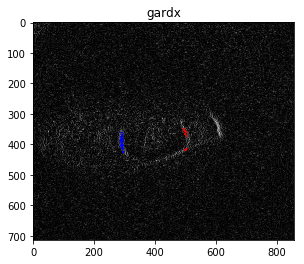

In [94]:
cargp_, cargn_, rargp_, rargn_, switch = debubble(cargpL, cargnL, rargpL, rargnL, win, 1)
lefteye = not switch
if (switch==1):
    cargp_, cargn_, rargp_, rargn_, switch = debubble(cargpR, cargnR, rargpR, rargnR, win, 0)
if (switch==1):
    print('both eyes failed')
fig, ax = plt.subplots(1)
ax.imshow(abs(gradx_),cmap='gray')
plt.title('gardx')
for i in range(len(cargn_)):
    ax.add_patch(plt.Circle((cargn_[i], rargn_[i]), radius=1, color='blue'))
for i in range(len(cargp_)):
    ax.add_patch(plt.Circle((cargp_[i], rargp_[i]), radius=1, color='red'))

((396.7569850716252, 388.9349526662691),
 [-206.2430149283748, 41.93495266626911])

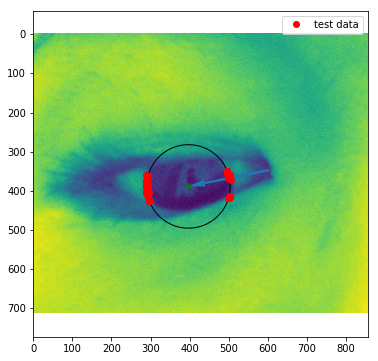

In [95]:
xcor = np.append(cargp_, cargn_)
ycor = np.append(rargp_, rargn_)
# efit ([xcor, ycor], isleft=1)

cfit ([xcor, ycor], isleft = lefteye)


t20 [215, -27] mag = 215.7

t21 [260, -18] mag = 260.8

t22 [217, 25]  mag = 217.4

t23 [263, 32]  mag = 263.4
